In [1]:
import numpy as np
import pickle
import pandas as pd
import scipy.stats as st
import os

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\AAM\False Rejects")
df=pd.read_pickle(os.getcwd()+"\Data Files\Transformed_NVH_DATA.pkl")
df.sort_values(by = 'PROD_TIMESTAMP', inplace = True)
df = df[df["STATIONNAME"]=="OP180B"]
df= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,5,22))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))]
df.reset_index(drop=True, inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [3]:
df1= pd.read_csv(os.getcwd()+"\\Data Files\\20200813.csv")
df1.columns = ['COLLID', 'PROD_TIMESTAMP', 'TOPLEVELSERIALNUMBER','PARTNUMBER', 'STATUS', 'Pinion Slide To Full Depth Posn',
               'NVH Torque Sweep Test Cycle Count','RH Slide To Full Depth Posn','LH Slide To Full Depth Posn']

df1["PROD_TIMESTAMP"] = pd.to_datetime(df1["PROD_TIMESTAMP"],format = '%Y-%m-%d %H:%M:%S.%f')
df1["FALSE_REJECT"] = np.where((df1["STATUS"] == 'A')& (df1["NVH Torque Sweep Test Cycle Count"]>1), 1,0)

In [4]:
df=pd.concat([df,df1])
df.sort_values(by = 'PROD_TIMESTAMP', inplace = True)
df.reset_index(drop=True, inplace = True)

In [5]:
df["ABNORMALITY_FLAG"]=np.where(((df.PROD_TIMESTAMP>=pd.datetime(2020,7,7,4)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,11,20)))
                            | ((df.PROD_TIMESTAMP>=pd.datetime(2020,7,16,17)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,18,5)))
                            | ((df.PROD_TIMESTAMP>=pd.datetime(2020,7,20,15)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,24,1)))  
                                ,1,0)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
df.head()

,SITENAME,LINENAME,STATIONNAME,PARTNUMBER,STATUS,TOPLEVELSERIALNUMBER,PROD_TIMESTAMP,COLLID,LH Slide To Full Depth Posn,NVH Torque Sweep Test Cycle Count,Pinion Slide To Full Depth Posn,RH Slide To Full Depth Posn,FALSE_REJECT,ABNORMALITY_FLAG
0,GMCFULL,T1XX Front Axle FA HiV,OP180B,40217205.0,A,01A200860353,2020-05-22 06:36:39.250,-1253555860,1084.90,1.0,251.954,1114.68,0,0
1,GMCFULL,T1XX Front Axle FA HiV,OP180B,40217205.0,A,01A200860371,2020-05-22 06:37:35.920,-1253555331,1086.09,1.0,251.470,1114.56,0,0
2,GMCFULL,T1XX Front Axle FA HiV,OP180B,40217205.0,A,01A200860365,2020-05-22 06:38:31.653,-1253555324,1086.10,1.0,251.741,1114.58,0,0
3,GMCFULL,T1XX Front Axle FA HiV,OP180B,40217205.0,A,01A200860811,2020-05-22 06:40:54.227,-1253554796,1086.00,1.0,251.485,1113.95,0,0
4,GMCFULL,T1XX Front Axle FA HiV,OP180B,40217205.0,A,01A200860787,2020-05-22 06:46:42.290,-1253553687,1085.17,1.0,251.935,1114.56,0,0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


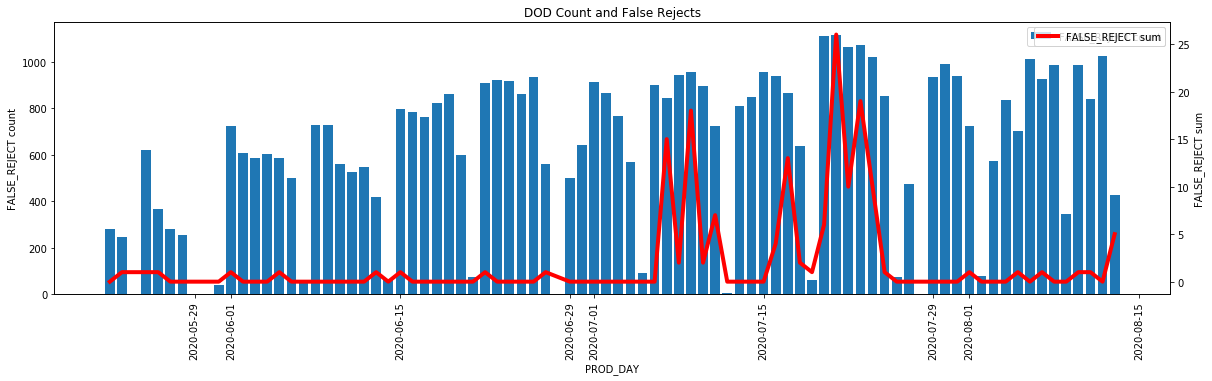

In [8]:
import matplotlib.pyplot as plt
df["PROD_DAY"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day))
df_dod = df[["PROD_DAY","FALSE_REJECT"]].groupby("PROD_DAY").agg(["sum","count"]).reset_index()
df_dod.columns = [' '.join(col).strip() for col in df_dod.columns.values]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(df_dod["PROD_DAY"],df_dod["FALSE_REJECT count"], label = 'FALSE_REJECT count')
plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT count')
plt.legend(loc="best")
plt.xticks(rotation = 90,)
ax2 = ax1.twinx()
ax2.plot(df_dod["PROD_DAY"],df_dod["FALSE_REJECT sum"],color='red', linewidth=4, markersize=12, label = 'FALSE_REJECT sum')
plt.title("DOD Count and False Rejects")
plt.legend(loc="best")


plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT sum')

plt.show()
# ax1.plot()

# df_dod.plot(x="PROD_DAY", y = ["FALSE_REJECT sum","FALSE_REJECT count"])

In [9]:
class anomaly_detection:
    def __init__(self, mean = 0, variance = 0, n_elements = 0, var_list = [], feature = 0, threshold_feature_eng = 100,
                baseline_obs = 10, current_obs = 10, p_value_warning = 0.001, p_value_anomaly = 0.0001, func='mean', 
                method = 'Z_SCORE'):
        self.mean = mean
        self.variance = variance 
        self.n_elements = n_elements
        self.var_list = var_list[:]
        self.feature = feature
        self.threshold_feature_eng = threshold_feature_eng
        self.baseline_obs = baseline_obs 
        self.current_obs = current_obs
        self.p_value_warning = p_value_warning
        self.p_value_anomaly = p_value_anomaly
        self.func = func
        self.method = method
        
#Add cutoffs here 
    def update(self, element):
        if self.method == 'Z_SCORE':
            warning_flag = 0
            anomaly_flag = 0 
            warning_text = 'NA'
            anomaly_text = 'NA'
            if len(self.var_list) >= self.threshold_feature_eng:
                self.var_list.pop(0)
            self.var_list.append(element)
            if len(self.var_list) >= self.baseline_obs + self.current_obs:
                if self.func == 'std':
                    self.feature = np.std(self.var_list[-(self.current_obs):])-np.std(self.var_list[-(self.baseline_obs+self.current_obs):-(self.current_obs)])
                elif self.func == 'median':
                    self.feature = np.median(self.var_list[-(self.current_obs):])-np.median(self.var_list[-(self.baseline_obs+self.current_obs):-(self.current_obs)])
                else :
                    self.feature = np.mean(self.var_list[-(self.current_obs):])-np.mean(self.var_list[-(self.baseline_obs+self.current_obs):-(self.current_obs)])

                z_anomaly = st.norm.ppf(1-self.p_value_anomaly)
                anomaly_flag = int(np.where((self.feature >= self.mean+z_anomaly*np.sqrt(self.variance)) | 
                                            (self.feature <= self.mean-z_anomaly*np.sqrt(self.variance)),1,0))
                anomaly_text = str(np.where((self.feature >= self.mean+z_anomaly*np.sqrt(self.variance)) | 
                                            (self.feature <= self.mean-z_anomaly*np.sqrt(self.variance)),
                                            'SHIFT:' + self.func + ' of current ' + str(self.current_obs) + ' observations shifted by ' + str(round(self.feature,2)) + ' compared to previous ' + str(self.baseline_obs) + ' observations'
                                            ,'NA'))


                z_warning = st.norm.ppf(1-self.p_value_warning)
                warning_flag = int(np.where((self.feature >= self.mean+z_warning*np.sqrt(self.variance)) | 
                                            (self.feature <= self.mean-z_warning*np.sqrt(self.variance)),1,0))
                warning_text = str(np.where((self.feature >= self.mean+z_warning*np.sqrt(self.variance)) | 
                                            (self.feature <= self.mean-z_warning*np.sqrt(self.variance)),
                                            'WARNING' + self.func + ' of current ' + str(self.current_obs) + ' observations shifted by ' + str(round(self.feature,2)) + ' compared to previous ' + str(self.baseline_obs) + ' observations'
                                            ,'NA'))


                self.variance = ((self.variance + self.mean ** 2) * self.n_elements + self.feature ** 2) / (self.n_elements + 1)
                self.mean = ((self.mean * self.n_elements) + self.feature) / (self.n_elements + 1)
                self.variance = self.variance - self.mean ** 2
                self.n_elements += 1

             
            
             
            
#             return (element,self.var_list,self.feature,self.mean,self.variance,self.func,anomaly_flag, anomaly_text, warning_flag, warning_text)
            return (anomaly_flag, anomaly_text, warning_flag, warning_text)
        


#### P value is basically proportion of population from 1 end that needs to be flagged. Effectively we end up flagging 2*P for both tails

In [11]:
class combined_anomaly:
    def __init__(self, mean = 0, variance = 0, n_elements = 0, var_list = [], feature = 0, threshold_feature_eng = 100,
                baseline_obs = 10, current_obs = 10,  p_value_warning = 0.001, p_value_anomaly = 0.0001, method = 'Z_SCORE'):
        self.mean_obj = anomaly_detection(mean = mean, variance = variance, n_elements = n_elements, 
                                      var_list = var_list, feature = feature, threshold_feature_eng = threshold_feature_eng,
                baseline_obs = baseline_obs, current_obs = current_obs, p_value_warning = p_value_warning, p_value_anomaly=p_value_anomaly, func="mean", method = method)
        self.std_obj = anomaly_detection(mean = mean, variance = variance, n_elements = n_elements, 
                                      var_list = var_list, feature = feature, threshold_feature_eng = threshold_feature_eng,
                baseline_obs = baseline_obs, current_obs = current_obs, p_value_warning = p_value_warning, p_value_anomaly=p_value_anomaly, func="std", method = method)
        self.median_obj = anomaly_detection(mean = mean, variance = variance, n_elements = n_elements, 
                                      var_list = var_list, feature = feature, threshold_feature_eng = threshold_feature_eng,
                baseline_obs = baseline_obs, current_obs = current_obs, p_value_warning = p_value_warning, p_value_anomaly=p_value_anomaly, func="median", method = method)
        
        
    def update(self, element):
            return({'mean': self.mean_obj.update(element),
                    'median': self.median_obj.update(element),
                    'std': self.std_obj.update(element)})
            


## Pinion Slide To Full Depth Posn

In [13]:
import time
start= time.time()
feature = 'Pinion Slide To Full Depth Posn'
data_stream = df[feature]

func = combined_anomaly(baseline_obs = 10, current_obs = 10, p_value_warning=0.001,
    p_value_anomaly=0.0001)

for i in range(len(data_stream)):
#     try:
        out = func.update(data_stream[i])
        (df.loc[df.index[i],"anomaly_flag_mean_pd"], df.loc[df.index[i],"anomaly_text_mean_pd"], df.loc[df.index[i],"warning_flag_mean_pd"], df.loc[df.index[i],"warning_text_mean_pd"]) = out["mean"]
        (df.loc[df.index[i],"anomaly_flag_median_pd"], df.loc[df.index[i],"anomaly_text_median_pd"], df.loc[df.index[i],"warning_flag_median_pd"], df.loc[df.index[i],"warning_text_median_pd"]) = out["median"]
        (df.loc[df.index[i],"anomaly_flag_std_pd"], df.loc[df.index[i],"anomaly_text_std_pd"], df.loc[df.index[i],"warning_flag_std_pd"], df.loc[df.index[i],"warning_text_std_pd"]) = out["std"]
#     except:
#         (df.loc[df.index[i],"anomaly_flag_mean_pd"], df.loc[df.index[i],"anomaly_text_mean_pd"], df.loc[df.index[i],"warning_flag_mean_pd"], df.loc[df.index[i],"warning_text_mean_pd"]) = (0,'NA',0,'NA')
#         (df.loc[df.index[i],"anomaly_flag_median_pd"], df.loc[df.index[i],"anomaly_text_median_pd"], df.loc[df.index[i],"warning_flag_median_pd"], df.loc[df.index[i],"warning_text_median_pd"]) = (0,'NA',0,'NA')
#         (df.loc[df.index[i],"anomaly_flag_std_pd"], df.loc[df.index[i],"anomaly_text_std_pd"], df.loc[df.index[i],"warning_flag_std_pd"], df.loc[df.index[i],"warning_text_std_pd"]) = (0,'NA',0,'NA')
print("Time taken: " + str(time.time()-start))
    

Time taken: 863.244211435318


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


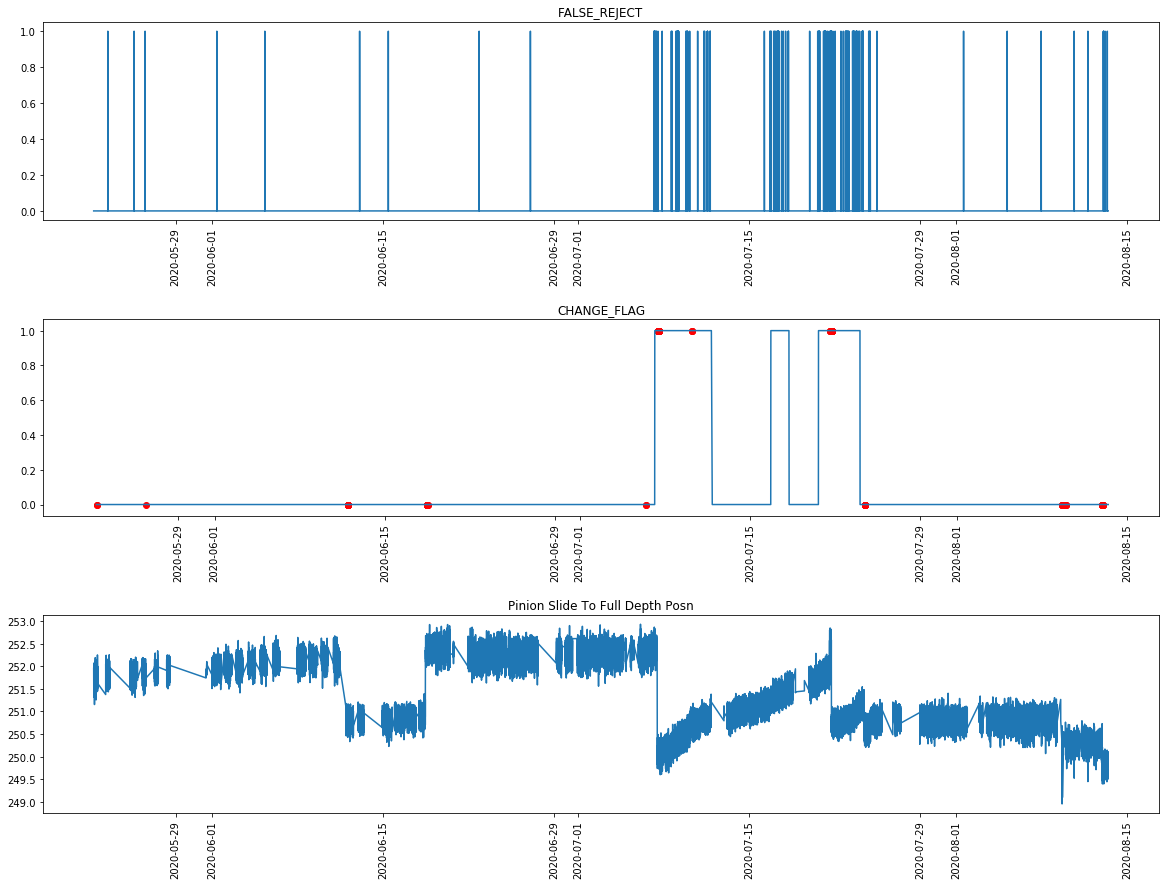

In [14]:
import matplotlib.pyplot as plt
df1=df
df1["DRIFT"]= df1["anomaly_flag_mean_pd"]
features=['Pinion Slide To Full Depth Posn']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

## LH Slide To Full Depth Posn

In [15]:
import time
start= time.time()
feature = 'LH Slide To Full Depth Posn'
data_stream = df[feature]

func = combined_anomaly(baseline_obs = 10, current_obs = 10, p_value_warning=0.001,
    p_value_anomaly=0.0001)

for i in range(len(data_stream)):
    try:
        out = func.update(data_stream[i])
        (df.loc[df.index[i],"anomaly_flag_mean_lh"], df.loc[df.index[i],"anomaly_text_mean_lh"], df.loc[df.index[i],"warning_flag_mean_lh"], df.loc[df.index[i],"warning_text_mean_lh"]) = out["mean"]
        (df.loc[df.index[i],"anomaly_flag_median_lh"], df.loc[df.index[i],"anomaly_text_median_lh"], df.loc[df.index[i],"warning_flag_median_lh"], df.loc[df.index[i],"warning_text_median_lh"]) = out["median"]
        (df.loc[df.index[i],"anomaly_flag_std_lh"], df.loc[df.index[i],"anomaly_text_std_lh"], df.loc[df.index[i],"warning_flag_std_lh"], df.loc[df.index[i],"warning_text_std_lh"]) = out["std"]
    except:
        (df.loc[df.index[i],"anomaly_flag_mean_lh"], df.loc[df.index[i],"anomaly_text_mean_lh"], df.loc[df.index[i],"warning_flag_mean_lh"], df.loc[df.index[i],"warning_text_mean_lh"]) = (0,'NA',0,'NA')
        (df.loc[df.index[i],"anomaly_flag_median_lh"], df.loc[df.index[i],"anomaly_text_median_lh"], df.loc[df.index[i],"warning_flag_median_lh"], df.loc[df.index[i],"warning_text_median_lh"]) = (0,'NA',0,'NA')
        (df.loc[df.index[i],"anomaly_flag_std_lh"], df.loc[df.index[i],"anomaly_text_std_lh"], df.loc[df.index[i],"warning_flag_std_lh"], df.loc[df.index[i],"warning_text_std_lh"]) = (0,'NA',0,'NA')
        
print("Time taken: " + str(time.time()-start))
    

Time taken: 864.249757528305


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


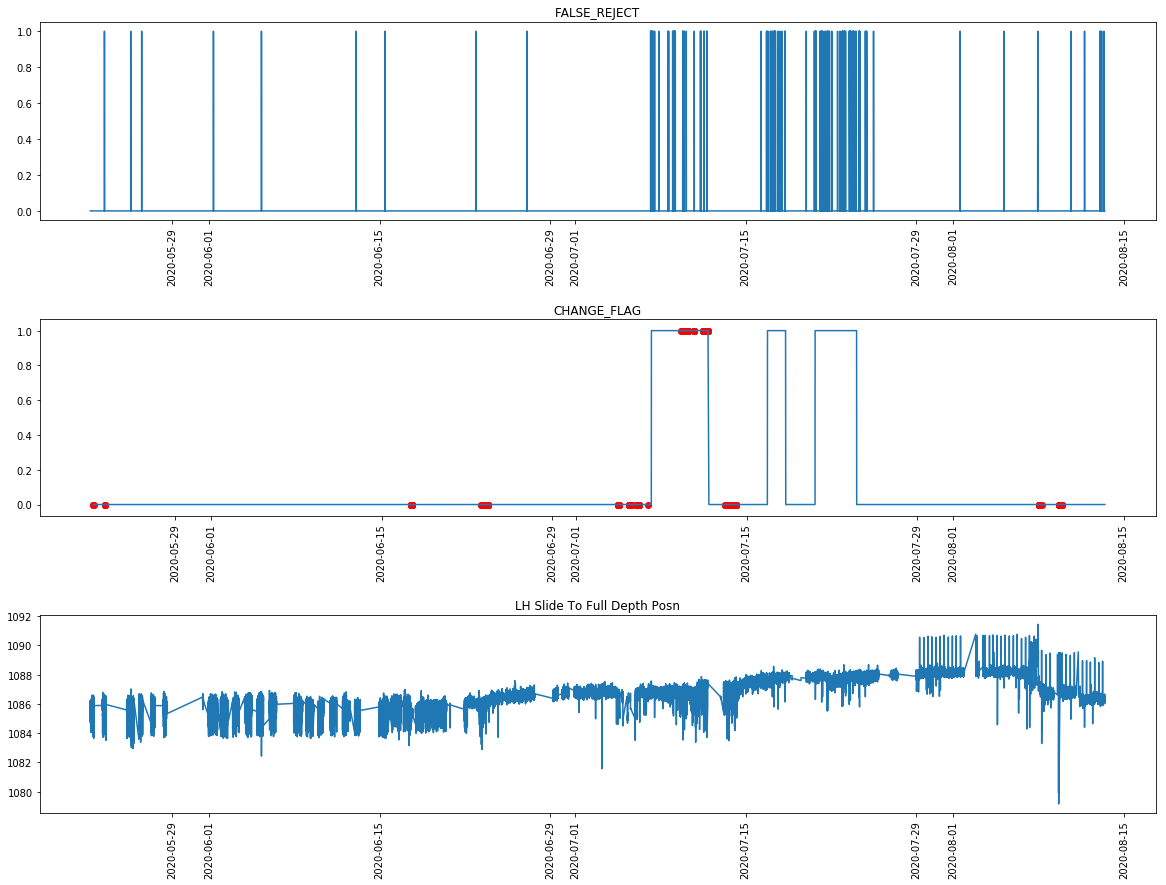

In [16]:
import matplotlib.pyplot as plt
df1=df
df1["DRIFT"]= df1["anomaly_flag_mean_lh"]
features=['LH Slide To Full Depth Posn']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

## RH Slide To Full Depth Posn

In [17]:
import time
start= time.time()
feature = 'RH Slide To Full Depth Posn'
data_stream = df[feature]

func = combined_anomaly(baseline_obs = 10, current_obs = 10, p_value_warning=0.001,
    p_value_anomaly=0.0001)

for i in range(len(data_stream)):
    out = func.update(data_stream[i])
    (df.loc[df.index[i],"anomaly_flag_mean_rh"], df.loc[df.index[i],"anomaly_text_mean_rh"], df.loc[df.index[i],"warning_flag_mean_rh"], df.loc[df.index[i],"warning_text_mean_rh"]) = out["mean"]
    (df.loc[df.index[i],"anomaly_flag_median_rh"], df.loc[df.index[i],"anomaly_text_median_rh"], df.loc[df.index[i],"warning_flag_median_rh"], df.loc[df.index[i],"warning_text_median_rh"]) = out["median"]
    (df.loc[df.index[i],"anomaly_flag_std_rh"], df.loc[df.index[i],"anomaly_text_std_rh"], df.loc[df.index[i],"warning_flag_std_rh"], df.loc[df.index[i],"warning_text_std_rh"]) = out["std"]

print("Time taken: " + str(time.time()-start))
    

Time taken: 821.588217496872


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


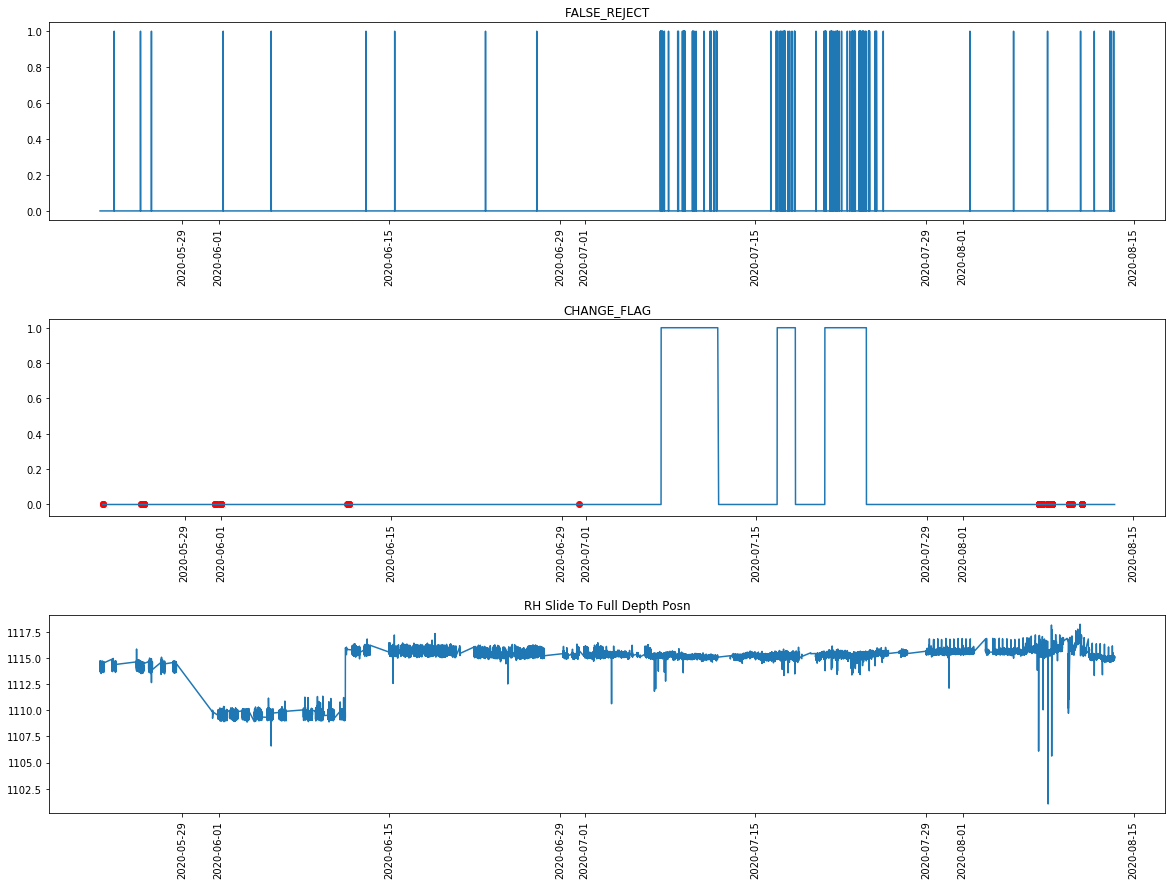

In [19]:
import matplotlib.pyplot as plt
df1=df
df1["DRIFT"]= df1["anomaly_flag_mean_rh"]
features=['RH Slide To Full Depth Posn']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

## Try with False reject (Maybe as an alternative to isolation forest)

In [312]:
import time
start= time.time()
feature = 'FALSE_REJECT'
data_stream = df[feature]

func_false_reject = combined_anomaly(baseline_obs = 100, current_obs = 100, p_value_warning=0.01,threshold_feature_eng=500,
    p_value_anomaly=0.00001)

for i in range(len(data_stream)):
    out = func_false_reject.update(data_stream[i])
    (df.loc[df.index[i],"anomaly_flag_mean_fr"], df.loc[df.index[i],"anomaly_text_mean_fr"], df.loc[df.index[i],"warning_flag_mean_fr"], df.loc[df.index[i],"warning_text_mean_fr"]) = out["mean"]
    (df.loc[df.index[i],"anomaly_flag_median_fr"], df.loc[df.index[i],"anomaly_text_median_fr"], df.loc[df.index[i],"warning_flag_median_fr"], df.loc[df.index[i],"warning_text_median_fr"]) = out["median"]
    (df.loc[df.index[i],"anomaly_flag_std_fr"], df.loc[df.index[i],"anomaly_text_std_fr"], df.loc[df.index[i],"warning_flag_std_fr"], df.loc[df.index[i],"warning_text_std_fr"]) = out["std"]

print("Time taken: " + str(time.time()-start))
    

Time taken: 765.3039631843567


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


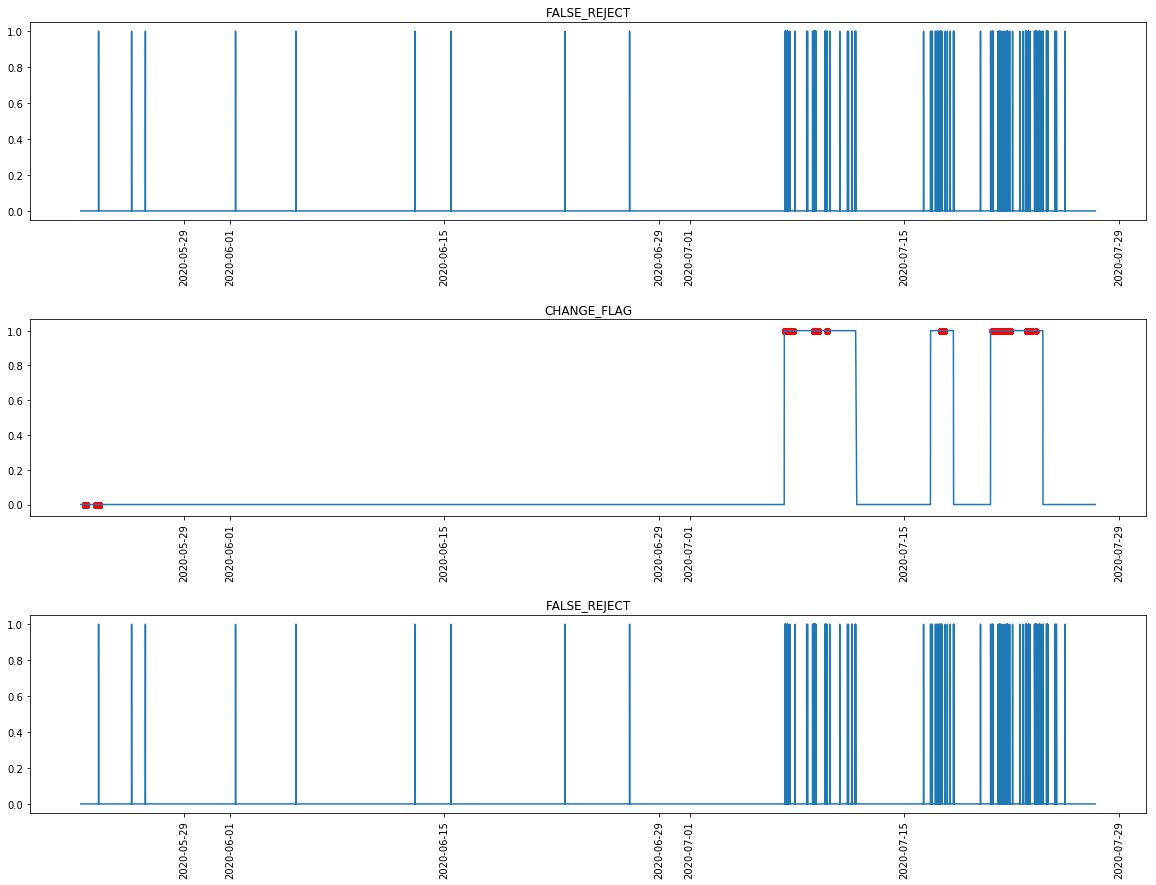

In [313]:
import matplotlib.pyplot as plt
df1=df
df1["DRIFT"]= df1["anomaly_flag_mean"]
features=['FALSE_REJECT']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

## Plot it on Power BI for better analysis